In [17]:
import numpy as np
import pandas as pd

import json
import torch
from torch import nn
from tqdm import tqdm
import faiss
import sqlite3
from transformers import BertModel, BertTokenizer

# For displaying thumbnail images
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
product_df = pd.read_csv('data/labeled_tools_and_home_improvement_products.csv')
product_df.head()

In [20]:
# Load in original data to add supplemental fields
file='data/meta_Tools_and_Home_Improvement.jsonl'

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [21]:
products[0]

{'main_category': 'Tools & Home Improvement',
 'title': 'Monster & Master 6" C-clamp Locking Plier without Swivel Pads, 3-Piece, MM-CP-004x3',
 'average_rating': 3.9,
 'rating_number': 168,
 'features': ['6" C-clamp locking pliers are ideal for clamping bulky work pieces.',
  'Heavy duty Chrome Vanadium steel jaws and teeth with premium wear and corrosion resistant nickel plating.',
  'Operation is as easy as turning the screw to adjust the pressure level and fit the object at hand.',
  'Classic trigger lock release securely lock the pliers in place while you work.',
  'Turn knob adjusts working pressure to lock securely at varying widths.'],
 'description': ['6" C-clamp locking pliers are ideal for clamping bulky work pieces.'],
 'price': None,
 'images': [{'thumb': 'https://m.media-amazon.com/images/I/41-IZsoY70L._AC_US75_.jpg',
   'large': 'https://m.media-amazon.com/images/I/41-IZsoY70L._AC_.jpg',
   'variant': 'MAIN',
   'hi_res': 'https://m.media-amazon.com/images/I/71nmsDlTpqL._

In [22]:
# APPEND NEW FIELDS TO DATA BY CREATING DICTIONARY WHERE KEYS ARE PARENT_ASIN AND VALUES ARE COLUMN VALUES
extra_product_info = {product['parent_asin']: [product['average_rating'], product['rating_number'], product['images'][0]['thumb'] if (len(product['images']) > 0) and ('thumb' in product['images'][0]) else '', product['store']] for product in products}

In [23]:
extra_product_df = pd.DataFrame.from_dict(extra_product_info, orient="index")

In [24]:
extra_product_df.columns = ['average_rating', 'number_of_ratings', 'thumbnail_image_link', 'store']

In [25]:
extra_product_df.head()

,average_rating,number_of_ratings,thumbnail_image_link,store
B07QQLKVQX,3.9,168,https://m.media-amazon.com/images/I/41-IZsoY70...,Monster & Master
B078RWZSYB,4.4,81,https://m.media-amazon.com/images/I/41K2XyoC7R...,PENCK
B07VH9GWPS,4.3,66,https://m.media-amazon.com/images/I/41Iizpcuvc...,SUNNY SHOWER
B07NC62X7H,5.0,1,https://m.media-amazon.com/images/I/41r9mlbg3r...,Kingston Brass
B00GIU9MVY,4.1,24,https://m.media-amazon.com/images/I/31XOUumH96...,Beme International


In [26]:
product_df = product_df.set_index('id')

In [27]:
final_df = product_df.join(extra_product_df)

In [28]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B09M8J9LQ9,Decute 200LED Christmas String Lights Outdoor ...,Specifications Light Color Multicolored Applic...,22,4.5,1255,https://m.media-amazon.com/images/I/51c4pBrjmd...,Decute
B0BNZ888C7,Upgrade Hydro Shower Jet Head High Pressure Hy...,HighPressure Filtered Shower Head with 3 Repla...,10,3.4,1905,https://m.media-amazon.com/images/I/51Gd-3aOtf...,Besititli
B07TLCQ3NR,"1"" Adhesive Furniture Sliders -Furnigear Chair...",Adhesive Furniture Glides SlidersFurnigear Hea...,17,3.9,1454,https://m.media-amazon.com/images/I/419SB+TlHK...,Furnigear
B09HRSKRFB,"Sunlite 40455 LED A19 Colored Light Bulb, 3 Wa...",Sunlites colored decorative A19 household ligh...,3,4.7,2352,https://m.media-amazon.com/images/I/41PWcd7cRl...,Sunlite
B014AV8FY2,Dixie Belle Paint Company Chalk Finish Furnitu...,CHALK MINERAL PAINT Amethyst is a rich deep m...,9,4.7,8455,https://m.media-amazon.com/images/I/41p0rJfu95...,Dixie Belle Paint Company


In [29]:
# Save final df
final_df.to_csv("data/final_home_products_df.csv", index=True)

In [32]:
# In the future, we can now simply read in this data frame rather than reproducing it every time
final_df = pd.read_csv("data/final_home_products_df.csv", index_col='id')

In [33]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B09M8J9LQ9,Decute 200LED Christmas String Lights Outdoor ...,Specifications Light Color Multicolored Applic...,22,4.5,1255,https://m.media-amazon.com/images/I/51c4pBrjmd...,Decute
B0BNZ888C7,Upgrade Hydro Shower Jet Head High Pressure Hy...,HighPressure Filtered Shower Head with 3 Repla...,10,3.4,1905,https://m.media-amazon.com/images/I/51Gd-3aOtf...,Besititli
B07TLCQ3NR,"1"" Adhesive Furniture Sliders -Furnigear Chair...",Adhesive Furniture Glides SlidersFurnigear Hea...,17,3.9,1454,https://m.media-amazon.com/images/I/419SB+TlHK...,Furnigear
B09HRSKRFB,"Sunlite 40455 LED A19 Colored Light Bulb, 3 Wa...",Sunlites colored decorative A19 household ligh...,3,4.7,2352,https://m.media-amazon.com/images/I/41PWcd7cRl...,Sunlite
B014AV8FY2,Dixie Belle Paint Company Chalk Finish Furnitu...,CHALK MINERAL PAINT Amethyst is a rich deep m...,9,4.7,8455,https://m.media-amazon.com/images/I/41p0rJfu95...,Dixie Belle Paint Company


Let's try testing our model with only the products that were successfully classified by BerTopic.

In [34]:
final_df = final_df.loc[final_df['label'] != -1]

In [46]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [47]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [81]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
query_encoder.load_state_dict(torch.load("data/home_products_query_encoder_v3.pt"))

description_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
description_encoder.load_state_dict(torch.load("data/home_products_description_encoder_v3.pt"))

<All keys matched successfully>

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [83]:
product_descriptions = list(final_df['description'])
product_ids = list(final_df.index)
batch_size=128
description_encoder = description_encoder.to(device)

sample_tokens = tokenizer(
    product_descriptions[0:1], 
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

with torch.no_grad():
    sample_embedding = description_encoder(sample_tokens)
embedding_dim = sample_embedding.shape[1]

# Create FAISS index based on requested type
index = faiss.IndexFlatIP(embedding_dim)

# Encode all products in batches and add to index
print("Encoding products and adding to index...")
batch_product_ids = []

# Create batches for product descriptions
batches = [product_descriptions[i:i + batch_size] for i in range(0, len(product_descriptions), batch_size)]
batch_ids = [product_ids[i:i + batch_size] for i in range(0, len(product_ids), batch_size)]

for batch_desc, batch_id in tqdm(zip(batches, batch_ids), total=len(batches), desc="Building index"):
    tokens = tokenizer(
        batch_desc, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=512
    )
    
    # Encode batch
    with torch.no_grad():
        embeddings = description_encoder(tokens)
        # Normalize embeddings for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
    # Add to index
    index.add(embeddings.cpu().numpy())
    batch_product_ids.extend(batch_id)

print(f"Index built with {len(batch_product_ids)} products")

Encoding products and adding to index...


Building index: 100%|████████████████████████████████████████████████████████████████| 108/108 [07:21<00:00,  4.09s/it]

Index built with 13823 products


In [84]:
faiss.write_index(index, "data/home_product_embeddings_v3.index")

In [85]:
# Create SQL Connection
conn = sqlite3.connect("home_product_embeddings.db")
cursor = conn.cursor()

In [57]:
# CREATE SQL TABLE
cursor.execute("DROP TABLE IF EXISTS products")

cursor.execute("""
    CREATE TABLE products (
        id TEXT PRIMARY KEY,
        product_name TEXT,
        seller TEXT,
        product_description TEXT,
        num_ratings INTEGER,
        avg_rating REAL,
        image_link TEXT
    )
    """)
conn.commit()

# POPULATE SQL TABLE WITH PRODUCT DATA
for row in final_df.itertuples(index=True, name=None):
    prod_id, prod_name, prod_desc, _, avg_rating, num_rating, image_url, store = row
    cursor.execute(
        """INSERT OR REPLACE INTO products
        (id, product_name, seller, product_description, num_ratings, avg_rating, image_link) VALUES (?, ?, ?, ?, ?, ?, ?)""",
        (prod_id, prod_name, store, prod_desc, num_rating, avg_rating, image_url)
    )
conn.commit()

In [86]:
res = cursor.execute("SELECT * FROM products LIMIT 1")
res.fetchall()

[('B09M8J9LQ9',
  'Decute 200LED Christmas String Lights Outdoor Waterproof 66FT with End-to-End Plug 8 Modes, Indoor Starry Fairy Lights for Christmas Tree Patio Garden Wedding Party Decor, Multicolored',
  'Decute',
  'Specifications Light Color Multicolored Application IndoorOutdoor LED Quantity 200 LED String Length 76ft  23m Work Mode 8 lighting modes Input Voltage 120V Output Voltage 30V Waterproof Rate IP55 Wire Length to First LED 99ft  3m LED Spacing 03ft  01m 8 Modes This string lights come with 8 lighting modes  Combination  In Waves  Sequential  SloGlo  ChasingFlash  Slow Fade  TwinkleFlash  Steay On IP55 Waterproof For Indoor And Outdoor High waterproof rank make it suitable for indoor and outdoor use Such as Wedding Holiday Christmas Garden YardLawn Fence Porch Tree Roof Deck and so on Max 4 Sets Expandable Each fairy light comes with end plug which makes you can connect them together Please notice that max 4 sets can be connected together Length of each string lights is 

In [87]:
def search(query, product_embeddings, k=10):
    query_tokens = tokenizer(
        query, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=32
    )
    
    with torch.no_grad():
        query_embedding = query_encoder(query_tokens)
        query_embedding = torch.nn.functional.normalize(query_embedding, p=2, dim=1)
    
    similarities, indices = product_embeddings.search(query_embedding.cpu().numpy(), k)
    
    similarities = similarities.reshape(-1)
    indices = indices.reshape(-1)
    top_product_ids = list(final_df.index[indices])
    
    placeholders = ', '.join(['?'] * len(top_product_ids))
    query = f"SELECT id, product_name, product_description, seller, image_link FROM products WHERE id IN ({placeholders})"
    res = cursor.execute(query, top_product_ids)
    query_results = res.fetchall()
    
    results = [{
        'product_id': query_result[0],
        'product_name': query_result[1],
        'product_description': query_result[2],
        'seller': query_result[3],
        'image_url': query_result[4],
        'similarity_score': similarity
    } for query_result, similarity in zip(query_results, similarities)]
    
    return results

In [88]:
# Read in index
index = faiss.read_index("data/home_product_embeddings_v3.index")

Queries that work well: "Tool repair kit", "Winter holiday string lights", "Open door with phone", "Face mask to protect mouth and eyes from dust"

In [122]:
search_results = search("Tool repair kit", index)

Product Name: Kershaw Clash (1605); Multi-Function; 3.1 Inch 3Cr13MoV Steel Blade; Bead-Blasted; Glass-Filled Synthetic Polymer Handle; SpeedSafe Assisted Opening; Liner Lock; Flipper; Reversible Pocketclip; 4.3 oz
Product Description: Product Description Ready to move in Kershaws twotoned Clash will make itself at home and stay a lifetime thanks to its many likable qualities Both durable and welldesigned for highend use Clash meets any need whether it be utility emergency tactical or recreational And while in use Clash delivers a comfortable secure grip thanks to a contoured and thicker textured handle made of synthetic polymer reinforced for strength stiffness and stability Additionally the 31 inch droppoint blade with beadb


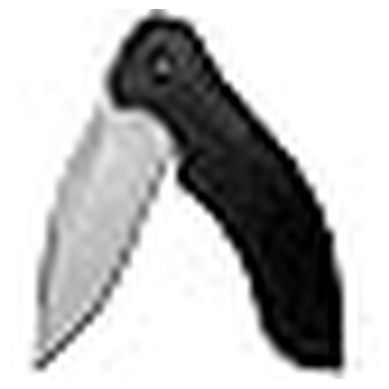

Product Name: 14-In-1 Multitool with Safety Locking, Professional Stainless Steel Multitool Pliers Pocket Knife, Bottle Opener, Screwdriver with Nylon Sheath ，Apply to Survival,Camping, Hunting and Hiking
Product Description: 14in1 Multitool Multitool with 14 function including pliers heads long nose pliers round nose pliers cutting pliers sharp knife philips screwdriver slotted screwdriverS serrated knife hook remover doublesided file slotted screwdriverL small scraper slotted screwdriverM can opener and bottle opener Safety Locking fangfo Multitool With side lock design every tool and knife  except the pliers heads  will be locked when fully open Ready for Anything You never know when you need a screwdriver plier o


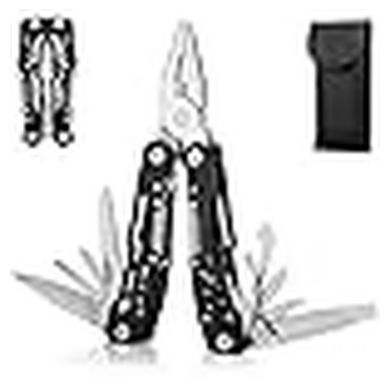

Product Name: MILWAUKEE ELECTRIC TOOL 49-22-8510 Milwaukee Kit Right Angle Attachment, 9.5" x 1.75" x 6"
Product Description: Product Description Milwaukees Right Angle Attachment allows contractors to drive screws and drill holes in tight difficult work areas This attachment is ideal for cordless drills and uses standard 14 inch hex accessories It has a durable allmetal housing and steel gears with ball bearing construction which allows this adapter to handle up to 235 inlbs of torque The compact design measures only 2 inches wide allowing it to fit in tight spaces where work is difficult to perform The convenient qui
No product image provided
Product Name: Screwdriver Set, 12 Pcs Small Screwdriver Set with Flathead Phillips Pentalobe Screwdriver In Different Sizes for iPhone PC Laptop Eyeglass Jewelry Watch
Product Description: Package Includes  1 x 30 Flathead Screwdriver 1 x 20 Flathead Screwdriver 1 x 15 Flathead Screwdriver 1 x 30 Phillips Screwdriver 1 x 20 Phillips Screwdriver 

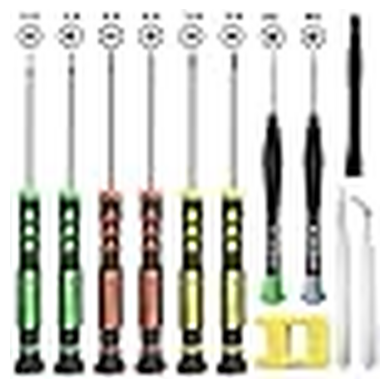

Product Name: New Mini 130 in 1 Screwdriver sets Magnetic, Hevanto Professional Precision Screwdriver Tools Sets, Repair for PC/Mobile Phone/Mobile Phone Case/Computer/Camera/Eyeglasses/Watch Hand Work
Product Description: 130 in 1 MINI SCREWDRIVER SET Precision screwdriver set contains 105 kinds of screwdriver bits 1 screwdriver handle 1 flexible extension shaft 1 tweezers 1 adapter lever 1 screw storage mat 1 plastic crowbar 14 triangular lever tools 1 magnetizer  demagnetizer 1 suction cup  1 SIM card pen Meet all of your home repair needs DURABLE MATERIAL This fine mechanical screwdriver set is made of superior CRV which is antistatic and durable Suitable for dismantling and maintaining various items such as l


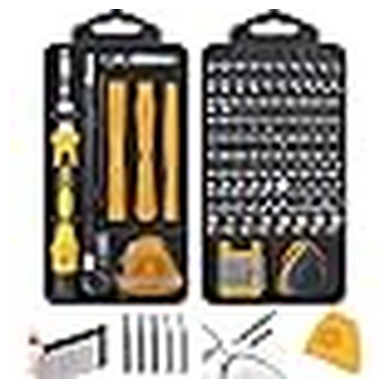

Product Name: Snowflake Multi-Tool, 3 Pcs 18-in-1 Snowflake Tool Stainless Steel with Storage Bag, Key Ring and Carabiner Clip (Black)
Product Description: Portable Size  The standard multitool snowflake has only 37 ounces and is just 248 inches diameter The portable size allows you easily put this multi screwdriver snowflake into your bag or pocket and carry it anywhere great for fishing mountaineering and other outdoor activities Multiple Applications  The multiuse snowflake multitool 18in1 tools can be used to open the beer bottle turn the screw repair bicycle and toys etc You can use it for outdoor adventures camping snowboarding and so on You 


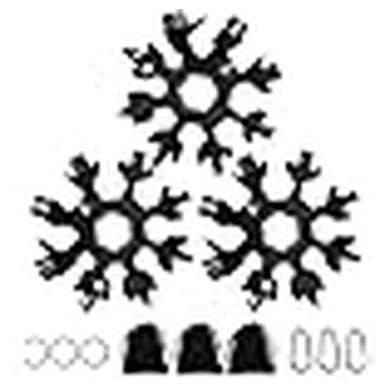

Product Name: Klein Tools 32215 1/4-Inch Slotted Screw-Holding Screwdriver, 7-Inch Length with Cushion Grip Handle
Product Description: This Slotted Screwholding Screwdriver from Klein Tools is designed to hold screws at the tip of the driver for exact placement It has a 7Inch long screwdriver shaft to place screws in hardtoreach areas The CushionGrip handle provides both strong torque and a comfortable grip For more than 160 years Klein Tools has manufactured premiumquality professionalgrade hand tools that deliver the performance durability and precision needed to get the job done right Our family of engineers workers and craf


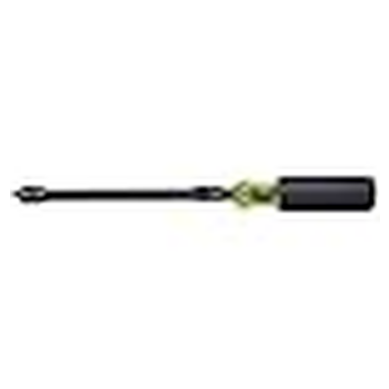

Product Name: Red Devil 3710 Wood Graining Tool, 6-Pack, 6 Pack
Product Description: The Red Devil Wood Graining Tool allows the DIYHobbyist or Professiol to create a high quality Faux Wood look quick and easy on any surface The tool has 2 different size attachments that sp easily on to the handle plus a triangle comb To use start by dragging curved graining tool in the wet glaze or stain Slide toward you as you slowly pivot downward Continue to pull and pivot up or down to create the desired look Repeat until the desired result is achieved Use the rrow curved grainer for tight 


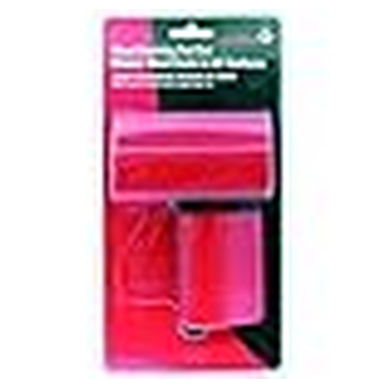

Product Name: Klein Tools 85742 Screwdriver Set, 3/16 Cabinet and 2 Phillips Precision Machined Tips, Cushion-Grip Handles, Round Shank, 2-Piece
Product Description: Klein Tools CushionGrip Screwdrivers are designed for demanding applications on the job site Durable cushiongrip handles are designed for comfort and added torque Integral flanges inside handle provide solid twist resistant blade anchor The precision machined tips provide an exact fit Special heattreated shafts with premium chrome plating for smooth feel and corrosion resistance Patented TipIdent quickly identifies the type of screwdriver and screwdriver tip orientation Meets or exceeds applicab


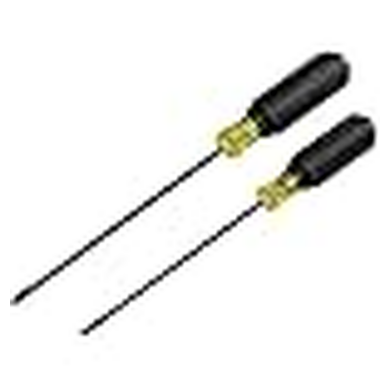

Product Name: FZENeast Snowflake Multitool, 3 Pcs 18-in-1 Stainless Steel Snowflake Standard Multitool, Snowflake Wrench with Key Ring, Carabiner Clip and Storage Pouch (Black)
Product Description: Gift Pouch Packaging  The gem glossy snowflake handy tool comes with a gift pouch a key ring and a stainless steel clip for  bearing weight up to about 2lbs wont be overweight Which is convenient to hang on the key and backpack or decorate in the Christmas tree Its unique snowflake shaped design is an ideal present for your families and friends 18 in 1 Snowflake Multitool  Our snowflake multipurpose tool contains incredible 18 tools a flat head screwdriver  2 and  3 Phillips screwdrivers 4 5 and


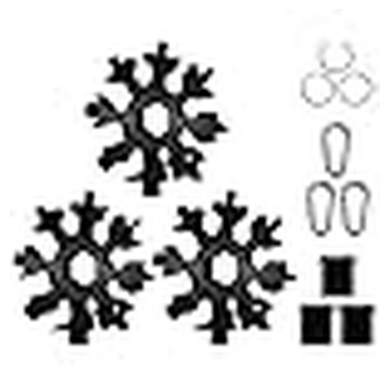

In [123]:
for result in search_results:
    try:
        # URL of the image
        image_url = result['image_url']
        
        # Fetch the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        
        target_size = (1000, 1000)
    
        # Calculate the aspect ratio
        img_ratio = img.width / img.height
        target_ratio = target_size[0] / target_size[1]
        
        if img_ratio > target_ratio:
            # Scale based on width
            new_width = target_size[0]
            new_height = int(new_width / img_ratio)
        else:
            # Scale based on height
            new_height = target_size[1]
            new_width = int(new_height * img_ratio)
        
        # Resize the image while maintaining the aspect ratio
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        # Display the resized image
        plt.imshow(img_resized)
        plt.axis('off')  # Hide the axes
        plt.show()
    except:
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        print("No product image provided")